In [1]:
import sys
import json
from collections import defaultdict, Counter
import itertools

from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor
from allennlp.models.ensemble import Ensemble

from tqdm import tqdm
import numpy as np

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline  

Using matplotlib backend: TkAgg


In [3]:
sys.path.append('../src/resolution/framework/models/')
sys.path.append('../src/resolution/framework/dataset_readers/')
sys.path.append('../src/resolution/framework/predictors/')
from model_base import NfhDetector
from nfh_reader import NFHReader
from model_base_predictor import NfhDetectorPredictor

In [4]:
def setting_output_span_indices(span_len, additional_classes):
    span_dic = {}
    counter = 0
    for c in additional_classes:
        span_dic[c] = counter
        counter += 1
    # 10000 is a random large number
    for i in range(10000):
        for j in range(1, span_len + 1):
            s = str(i) + ':' + str(i + j)
            span_dic[s] = counter
            counter += 1

    return dict(span_dic)

span_d = setting_output_span_indices(1, ['YEAR', 'AGE', 'CURRENCY', 'PEOPLE', 'TIME', 'OTHER'])
label_dict = {v: k for k, v in span_d.items()}

In [5]:
def get_closest_head(heads, anchors_indices):
    closest_ref = heads[0]
    closest_dist = abs(closest_ref - anchors_indices[0])
    for i in range(len(heads)):
        new_dist = abs(heads[i] - anchors_indices[0])
        if new_dist < closest_dist:
            closest_dist = new_dist
            closest_ref = heads[i]

    ref_ind = str(closest_ref) + ':' + str(closest_ref + 1)
    head = span_d[ref_ind]
    return head

In [6]:
archive_elmo = load_archive('../src/allen_logs/elmo_shuffle/model.tar.gz')#, cuda_device=3)
predictor_elmo = Predictor.from_archive(archive_elmo, 'nfh_classification')

/home/nlp/lazary/anaconda2/envs/allennlp/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [7]:
def get_data(f_name):
    with open(f_name, 'r') as f:
        lines = f.readlines()

    lines = [line.strip() for line in lines]
    return lines

lines_train = get_data('../data/resolution/processed/final/shuffle/json_train.txt')
lines_dev = get_data('../data/resolution/processed/final/shuffle/json_dev.txt')
lines_test = get_data('../data/resolution/processed/final/shuffle/json_test.txt')

In [8]:
def get_batched_predictions(predictor, data, limit=10000000000, bs=100):
    predictions = []
    for i in tqdm(range(1, int(limit / bs))):
        batched_lines = [json.loads(x) for x in data[len(predictions): i * bs]]
        y_hats = predictor.predict_batch_json(batched_lines)
        predictions += y_hats
        
    batched_lines = [json.loads(x) for x in data[len(predictions): limit]]
    y_hats = predictor.predict_batch_json(batched_lines)
    predictions += y_hats
    return predictions

In [9]:
elmo_preds_dev = get_batched_predictions(predictor_elmo, lines_dev, limit=1000, bs=20)

100%|██████████| 49/49 [02:44<00:00,  3.35s/it]


In [23]:
import torch
torch.cuda.empty_cache()

In [10]:
implicit_classes = ['YEAR', 'AGE', 'CURRENCY', 'PEOPLE', 'TIME', 'OTHER']

In [12]:
from sklearn.metrics import f1_score
def f1_calc(lines, predictions):
    
    total_correct = 0
    ys, yhs = [], []
    for dev_ex, dev_pred in zip(lines, predictions):
        ex = json.loads(dev_ex)
        if ex['head'][0].__class__ is str:
            ys.append(implicit_classes.index(ex['head'][0]))
            
#             print(implicit_classes.index(ex['head'][0]), dev_pred['y_hat'])
            if implicit_classes.index(ex['head'][0]) == dev_pred['y_hat']:
                total_correct += 1
            
            if dev_pred['y_hat'] < 6:
                yhs.append(dev_pred['y_hat'])
            else:
                yhs.append(7)
        else:
            closest_head = get_closest_head(ex['head'], ex['anchors_indices'])
#             print(closest_head, dev_pred['y_hat'])
            if closest_head == dev_pred['y_hat']:
                total_correct += 1
            ys.append(6)
            if dev_pred['y_hat'] >= 6:
                
                if closest_head == dev_pred['y_hat']:
                    yhs.append(6)
                else:
                    yhs.append(7)
            else:
                yhs.append(dev_pred['y_hat'])
    print(f1_score(ys, yhs, average='macro'))
    print(float(total_correct) / len(lines))

f1_calc(lines_dev, elmo_preds_dev)

0.7300847180173915
0.753


/home/nlp/lazary/anaconda2/envs/allennlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [14]:
def calc_score(lines, predictions, inclusive=False):
    total_correct = 0
    for dev_ex, dev_pred in zip(lines, predictions):
        ex = json.loads(dev_ex)
        y_hat = dev_pred['y_hat']
        if ex['head'][0].__class__ is str:
            if implicit_classes.index(ex['head'][0]) == y_hat:
                total_correct += 1

        else:
            
            tokens = ex['tokens']
            heads = [tokens[x].lower() for x in ex['head']]
            
            closest_head = get_closest_head(ex['head'], ex['anchors_indices'])
#             print(y_hat)
#             print(heads)
            if closest_head == y_hat:
                total_correct += 1
            elif inclusive and y_hat >= 6 and tokens[y_hat-6].lower() in heads:
                total_correct += 1
            
    print(float(total_correct) / len(lines))

calc_score(lines_dev, elmo_preds_dev, True)

0.772


In [15]:
implicit_classes = ['YEAR', 'AGE', 'CURRENCY', 'PEOPLE', 'TIME', 'OTHER']
num_implicit = len(implicit_classes)

def calc_confusion_mat(predictions, data):
    exact = 0
    one_of = 0
    errs = []
    err_mat = []
    preds_mat = []
    one_errs = 0

    for ind, (example, prediction) in enumerate(zip(data, predictions)):
        example = json.loads(example)
        tokens = example['tokens']
        
        y_hat = prediction['y_hat']
        y = example['head']
        if len(y) == 1 and y[0] in implicit_classes:
            y = implicit_classes.index(y[0])

        anchors_indices = example['anchors_indices']
        if y.__class__ == list:
            closest_y = get_closest_head(y, anchors_indices)
            if closest_y == y_hat:
                exact += 1
                one_of +=1
                preds_mat.append((6, 6))
            elif y_hat - 6 in y:
                one_of += 1
                preds_mat.append((6, 6))
            else:
                errs.append((example, prediction, ind))
                if y_hat < num_implicit:
                    err_mat.append('Ref_' + implicit_classes[y_hat])
                    preds_mat.append((6, y_hat))
                else:
                    err_mat.append('Ref_Ref')
                    preds_mat.append((6, 7))
        else:
            if y == y_hat:
                exact += 1
                one_of += 1
                preds_mat.append((y, y))
            else:
                errs.append((example, prediction, ind))
                if y_hat < num_implicit:
                    err_mat.append(implicit_classes[y] + '_' + implicit_classes[y_hat])
                    preds_mat.append((y, y_hat))
                else:
                    err_mat.append(implicit_classes[y] + '_Ref')
                    preds_mat.append((y, 7))
    
    print(Counter(err_mat))
    return errs, err_mat, preds_mat

In [16]:
elmo_errs, _, preds_mat = calc_confusion_mat(elmo_preds_dev, lines_dev)

Counter({'Ref_OTHER': 51, 'Ref_Ref': 48, 'OTHER_Ref': 44, 'PEOPLE_OTHER': 13, 'Ref_PEOPLE': 13, 'PEOPLE_Ref': 11, 'OTHER_PEOPLE': 10, 'CURRENCY_OTHER': 6, 'Ref_CURRENCY': 5, 'Ref_AGE': 5, 'OTHER_CURRENCY': 5, 'OTHER_YEAR': 2, 'Ref_YEAR': 2, 'CURRENCY_Ref': 2, 'Ref_TIME': 2, 'OTHER_AGE': 2, 'AGE_Ref': 2, 'YEAR_Ref': 1, 'PEOPLE_TIME': 1, 'TIME_Ref': 1, 'AGE_OTHER': 1, 'TIME_OTHER': 1, 'YEAR_AGE': 1})


In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix([x[0] for x in preds_mat], [x[1] for x in preds_mat])

array([[ 44,   1,   0,   0,   0,   0,   0,   1],
       [  0, 105,   0,   0,   0,   1,   0,   2],
       [  0,   0,  32,   0,   0,   6,   0,   2],
       [  0,   0,   0,  68,   1,  13,   0,  11],
       [  0,   0,   0,   0,  30,   1,   0,   1],
       [  2,   2,   5,  10,   0, 154,   0,  44],
       [  2,   5,   5,  13,   2,  51, 338,  48],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

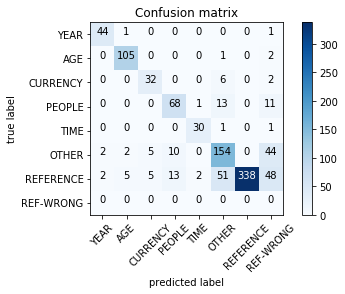

In [20]:
labels = ['YEAR', 'AGE', 'CURRENCY', 'PEOPLE', 'TIME', 'OTHER', 'REFERENCE', 'REF-WRONG']

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
plot_confusion_matrix(confusion_matrix([x[0] for x in preds_mat], [x[1] for x in preds_mat]), labels)

### Data Inspection

In [25]:
def inspect_ex(example):
    example = json.loads(example)
    tokens = example['tokens']
    anchors_inds = example['anchors_indices']
    
    anchored_text = tokens[:anchors_inds[0]] + ['***'] + tokens[anchors_inds[0]: anchors_inds[-1] + 1] + ['***'] + tokens[anchors_inds[-1] + 1:]
    
    print('text:', ' '.join(anchored_text))
    print('y:', example['head'], end=', ')
    for head in example['head']:
        if head not in span_d:
            print(tokens[head], end=', '),
        else:
            print(head, end=', ')
    print()
    
inspect_ex(lines_dev[0])

text: You are such a slut ! Well , it takes one to know *** one *** , does n't it , dear ?
y: [4], slut, 


In [26]:
def make_prediction(predictor, tokens, anchor_inds):
#     tokens = text.split()
    
    example = {'tokens': tokens, 'anchors_indices': anchor_inds}
    prediction = predictor.predict_json(example)
    y_hat = prediction['y_hat']
#     print(y_hat)
    if y_hat < len(implicit_classes):
        print(implicit_classes[y_hat])
    else:
        print(tokens[y_hat - len(implicit_classes)])
    return prediction
    
    
# make_prediction(predictor_elmo, "You forget , Doctor , I'M the one who asks the riddles .", [7])

In [27]:
def inspect_err(example, prediction, index):
    tokens = example['tokens']
    anchors_inds = example['anchors_indices']
    
    anchored_text = tokens[:anchors_inds[0]] + ['***'] + \
        tokens[anchors_inds[0]: anchors_inds[-1] + 1] + ['***'] + \
        tokens[anchors_inds[-1] + 1:]
    
    print(index, ' '.join(anchored_text), end='\t')
#     print('y:', example['head'], end='***')
    for head in example['head']:
        if head not in span_d:
            print(tokens[head], end=', '),
        else:
            print(head, end=', ')
    print('\t', end='')
    
    y_hat = prediction['y_hat']
    if y_hat < 6:
        y_hat = label_dict[y_hat]
    else:
#         print(y_hat)
        y_hat -= 6
#         y_hat = '{0}, {1}'.format(y_hat, tokens[y_hat])
        y_hat = '{0}'.format(tokens[y_hat])
    
    print(y_hat)
    print()

inspect_err(*elmo_errs[1])

24 How has life been without a father ? Okay . I really miss him . But you have Héctor as a legal dad . He might be my legal dad , too ! No , because we 're not sisters , but you can look for another one . How did you look for *** one *** ? I think my brother found him on the internet .	dad, dad, 	sisters



### Errors

In [34]:
for ex in elmo_errs[:200]:
    tokens = ex[0]['tokens']
    anchors_inds = ex[0]['anchors_indices']
#     if tokens[anchors_inds[0]] in ['one', '1']: continue
    inspect_err(*ex)

7 You do plenty of things for me . Name *** one *** . One ? I 'll name a bunch ! You tell me when my shoelaces are untied . You come over and wake me up at six o'clock every Saturday and Sunday morning just to remind me there 's no school . You ... you ... uh ... did I mention the shoelaces ?	plenty, 	things

24 How has life been without a father ? Okay . I really miss him . But you have Héctor as a legal dad . He might be my legal dad , too ! No , because we 're not sisters , but you can look for another one . How did you look for *** one *** ? I think my brother found him on the internet .	dad, dad, 	sisters

27 Let me in ! Over my dead body , Chuck ! How about over your tranq'd body ? You were distracting me so she could break in . Yeah . Clever girl . Are you using the 5 milligram darts ? *** 10 *** . Please tell Casey I put up a good fight .	darts, 	OTHER

28 Simon wants to know if you can get the ring road plan scrapped , Rita . Tell him , no , I ca n't get it scrapped . No , she

In [23]:
implicit_classes = ['YEAR', 'AGE', 'CURRENCY', 'PEOPLE', 'TIME', 'OTHER']
num_implicit = len(implicit_classes)

def get_top_predictions(predictor, in_text):
    split_text = in_text.split()
    split_text_update = []
    anchor_start = 0
    anchor_end = 0
    in_anchor = False
    for ind, w in enumerate(split_text):
        if w == '***':
            if in_anchor:
                anchor_end = ind - 2
            else:
                anchor_start = ind
                in_anchor = True
        else:
            split_text_update.append(w)

    anchor = [anchor_start]
    if anchor_end - anchor_start > 0:
        anchor.append(anchor_end)

    sample_data = {"tokens": split_text_update,
              "anchors_indices": anchor}
    print(' '.join(split_text_update))
    print(anchor)
    prediction = predictor.predict_json(sample_data)
#     print(len(prediction['tag_logits']))

    y_hat = prediction['y_hat']
    if y_hat < num_implicit:
        y_hat = implicit_classes[y_hat]
    else:
        y_hat = split_text_update[y_hat - num_implicit]

    print(y_hat)
    # print(prediction)
    l = np.array(prediction['tag_logits'])
    probs = np.e ** l / sum(np.e ** l)
    for i, j, p in zip(l.argsort()[-10:][::-1], sorted(l, reverse=True), sorted(probs, reverse=True)):
        if i < num_implicit:
            yh = implicit_classes[i]
        else:
            yh = split_text_update[i - num_implicit]
        print (yh, j, p),



In [30]:
# text = "I have only followed my lover . I hope you have *** one *** ."
# text = "Speaking of parties , I 'm having *** one *** and we 'd like to invite you as the official guest of honor . Why ? So you and your little \" descendants club \" can burn me at the stake and roast marshmallows by the fire ?"
# text = "Is this your dog ? I 've never seen this *** one *** ."
text = "How has life been without a father ? Okay . I really miss him . But you have Héctor as a legal dad . He might be my legal dad , too ! No , because we 're not sisters , but you can look for another one . How did you look for *** one *** ? I think my brother found him on the internet ."

get_top_predictions(predictor_elmo, text)

How has life been without a father ? Okay . I really miss him . But you have Héctor as a legal dad . He might be my legal dad , too ! No , because we 're not sisters , but you can look for another one . How did you look for one ? I think my brother found him on the internet .
[54]
sisters
sisters 3.93868350982666 0.5721180688322326
dad 3.0803730487823486 0.24250805421346777
OTHER 2.774381637573242 0.1785812200233018
father -1.4036058187484741 0.002737530004270275
dad -1.7139393091201782 0.0020071635678537967
PEOPLE -2.044800043106079 0.0014417560231763653
TIME -4.191709041595459 0.00016846164734377864
He -4.43220853805542 0.00013245045026502957
AGE -4.98041296005249 7.65545985824329e-05
life -5.155336380004883 6.426921680342549e-05


In [31]:
text = "Simon wants to know if you can get the ring road plan scrapped , Rita . Tell him , no , I ca n't get it scrapped . No , she ca n't get it scrapped . Damn ! Damn ! Thank you , Simon . What on earth for ? Because every time I meet you , I get to thinking my *** two *** are n't such berks after all ."
get_top_predictions(predictor_elmo, text)

Simon wants to know if you can get the ring road plan scrapped , Rita . Tell him , no , I ca n't get it scrapped . No , she ca n't get it scrapped . Damn ! Damn ! Thank you , Simon . What on earth for ? Because every time I meet you , I get to thinking my two are n't such berks after all .
[63]
OTHER
OTHER 5.06685209274292 0.997910283526208
PEOPLE -1.4529848098754883 0.001470829420619636
berks -2.6759040355682373 0.00043296743904961565
earth -4.333721160888672 8.250388650270839e-05
AGE -5.002892971038818 4.225292538148275e-05
CURRENCY -5.651818752288818 2.2081669058169823e-05
TIME -6.403280258178711 1.0415408581713136e-05
for -7.103644847869873 5.1702534698744615e-06
time -7.377061367034912 3.933403946760267e-06
plan -7.990231037139893 2.130454900233321e-06


In [35]:
text = "Another lesson ? Uh - huh . What was this *** one *** about ? Uh ... Beauty ... In the dark ... Well ... They must be working . You 're beginning to sound just like a Vorlon ."
get_top_predictions(predictor_elmo, text)

Another lesson ? Uh - huh . What was this one about ? Uh ... Beauty ... In the dark ... Well ... They must be working . You 're beginning to sound just like a Vorlon .
[10]
OTHER
OTHER 1.6224271059036255 0.4187759723426003
Beauty 1.2936509847640991 0.3014366818249482
lesson 1.1983652114868164 0.2740400353975046
PEOPLE -2.7678146362304688 0.005191872191068262
TIME -5.985548496246338 0.00020791218052941107
AGE -6.682919025421143 0.00010351797326650095
CURRENCY -8.042336463928223 2.6584486034893e-05
Vorlon -8.26616382598877 2.125305079332383e-05
YEAR -8.274372100830078 2.1079313926642086e-05
... -8.680598258972168 1.4042185078036054e-05


In [36]:
text = "I 've still got $ 30 . I was thinkin ' I might split it with ya , and then again I might get back in that poker game and run it up to a thousand . But , what if you lose the thirty ? You do n't get the fifteen . But , if ya win the *** thousand *** ? You do get the fifteen . Bret , sometimes your heart runs away with your head ."
get_top_predictions(predictor_elmo, text)

I 've still got $ 30 . I was thinkin ' I might split it with ya , and then again I might get back in that poker game and run it up to a thousand . But , what if you lose the thirty ? You do n't get the fifteen . But , if ya win the thousand ? You do get the fifteen . Bret , sometimes your heart runs away with your head .
[59]
OTHER
OTHER 5.734511375427246 0.9764203133177339
CURRENCY 1.9966585636138916 0.02324384418612038
PEOPLE -2.7064590454101562 0.0002107511388674918
TIME -4.159891605377197 4.9266554384775e-05
AGE -5.206862926483154 1.7292521411253495e-05
. -5.2802252769470215 1.606931847707486e-05
heart -5.866672039031982 8.939369018643618e-06
game -6.029654026031494 7.594945954759041e-06
YEAR -6.236283779144287 6.177126940497767e-06
. -6.796090602874756 3.529112571914589e-06


In [37]:
text = "Mrs. Draper is back for her 27th hospital admission status , post - pancreatic pseudocyst . *** 27 *** ? Yes , somebody needs to tell her the hospital stopped giving out frequent - flier miles . Oh , and she 's a chronic rectal discomfort , and you two get to work her up and review her old charts . All 27 ? No , why do n't you just forget all about visits 6 , 13 , and uh , what do you think , 21 ? Yeah , that should keep it interesting . It 'll be like playing patient roulette ."
get_top_predictions(predictor_elmo, text)

Mrs. Draper is back for her 27th hospital admission status , post - pancreatic pseudocyst . 27 ? Yes , somebody needs to tell her the hospital stopped giving out frequent - flier miles . Oh , and she 's a chronic rectal discomfort , and you two get to work her up and review her old charts . All 27 ? No , why do n't you just forget all about visits 6 , 13 , and uh , what do you think , 21 ? Yeah , that should keep it interesting . It 'll be like playing patient roulette .
[16]
AGE
AGE 5.027385234832764 0.6954892062069863
visits 4.106464862823486 0.2769107133532037
charts 1.7674353122711182 0.026700053501590455
OTHER -2.7430260181427 0.000293524032326317
miles -2.8271937370300293 0.0002698299103682372
status -3.534566879272461 0.00013300924760212482
pseudocyst -3.667504072189331 0.00011645226700084518
YEAR -5.090419292449951 2.8066206682748114e-05
admission -5.904346466064453 1.2436541943577308e-05
flier -6.394830703735352 7.615265355676756e-06


In [38]:
text = "Sam , you got a very understanding brain ... for larceny . I found out early in life that the honest dollar is the hardest *** one *** to make ."
get_top_predictions(predictor_elmo, text)

Sam , you got a very understanding brain ... for larceny . I found out early in life that the honest dollar is the hardest one to make .
[25]
OTHER
OTHER 4.923346519470215 0.6126178432618256
dollar 4.453970432281494 0.38312650460987946
PEOPLE -0.13947850465774536 0.0038764364734861496
is -2.842129707336426 0.00025982812981262493
life -5.156413555145264 2.5680617524625857e-05
TIME -5.215183734893799 2.4214856401553367e-05
brain -5.537186145782471 1.7548420305965466e-05
CURRENCY -5.7534499168396 1.4135652664794723e-05
larceny -6.1540913581848145 9.469335373307459e-06
make -6.430971622467041 7.179131811423497e-06


In [39]:
text = "What are your sales ? 100 . *** 100000 *** ? No , 100 ."
get_top_predictions(predictor_elmo, text)

What are your sales ? 100 . 100000 ? No , 100 .
[7]
CURRENCY
CURRENCY 3.1905179023742676 0.9342454502820416
OTHER 0.5184298753738403 0.06456362498286514
TIME -4.0666279792785645 0.0006587529616890884
PEOPLE -5.2894368171691895 0.00019393824000271
sales -5.291808605194092 0.00019347880466449245
AGE -5.700727939605713 0.0001285410920159376
YEAR -8.775856018066406 5.936504884890387e-06
What -10.119528770446777 1.5487494589268626e-06
are -10.514447212219238 1.0434466944691675e-06
. -10.64787769317627 9.13107996262016e-07


In [40]:
text = "How long have you lived like this ? I worked construction for a while , but no one wants an old man on the job when they can get somebody younger and cheaper . How long ? A year . Maybe *** five *** . It 's hard to keep track without a watch . Then let me help you . If I had wanted your help , I would have asked for it ."
get_top_predictions(predictor_elmo, text)

How long have you lived like this ? I worked construction for a while , but no one wants an old man on the job when they can get somebody younger and cheaper . How long ? A year . Maybe five . It 's hard to keep track without a watch . Then let me help you . If I had wanted your help , I would have asked for it .
[41]
AGE
AGE 3.4741621017456055 0.6758435838832788
year 2.673842430114746 0.3035790363328885
CURRENCY -0.7270902395248413 0.010121980266360275
PEOPLE -1.1446467638015747 0.00666688543057767
TIME -1.9946421384811401 0.0028495395626233996
OTHER -3.825166702270508 0.00045686509000595254
man -4.628636360168457 0.00020457169105394886
YEAR -4.767235279083252 0.00017809543577205944
one -7.414393901824951 1.2618461498468386e-05
you -7.567183017730713 1.0830560607520305e-05


In [41]:
text = "This will be my gift to the Dragon Flyz , my farewell gift . *** One *** that will keep giving and giving and giving ."
get_top_predictions(predictor_elmo, text)

This will be my gift to the Dragon Flyz , my farewell gift . One that will keep giving and giving and giving .
[14]
PEOPLE
PEOPLE -0.44004571437835693 0.7611356143299124
gift -2.2895307540893555 0.11974045288193168
OTHER -2.877572536468506 0.06650550494222879
CURRENCY -3.2696094512939453 0.044936384441087336
YEAR -6.180077075958252 0.002446797889503225
gift -6.413337230682373 0.0019377355152342217
Flyz -7.174562931060791 0.0009051037786904341
TIME -7.429234027862549 0.0007016105744909896
AGE -7.823001384735107 0.00047324402097261064
giving -8.400769233703613 0.0002655606647553674


In [42]:
text = "You out of your mind ? Just a little . I ca n't quite seem to adjust : two daughters - in - law for only one son . Well , as long as you had only *** one *** , why 'd it have to be me ?"
get_top_predictions(predictor_elmo, text)

You out of your mind ? Just a little . I ca n't quite seem to adjust : two daughters - in - law for only one son . Well , as long as you had only one , why 'd it have to be me ?
[37]
daughters
daughters 8.030106544494629 0.9705172498776387
son 4.534372806549072 0.02943238029097774
OTHER -1.913547396659851 4.66153792960114e-05
PEOPLE -5.518788814544678 1.2670471272860444e-06
AGE -6.112141132354736 7.000082059658544e-07
law -7.119243144989014 2.556962061693088e-07
mind -7.178742408752441 2.409262286358273e-07
CURRENCY -7.550235748291016 1.6616768711807585e-07
TIME -7.60316801071167 1.5760078831754104e-07
little -7.97070837020874 1.0912836173135348e-07


In [43]:
text = "Oh , now you love the ten commandments , yet you 're the one who so conveniently forgot \" Thou shalt protect thy father , and honor no one above him , unless it be - eth me , thy sweet Lord . \" I 'm not sure that *** one *** made it down the mountain , Gob ."
get_top_predictions(predictor_elmo, text)

Oh , now you love the ten commandments , yet you 're the one who so conveniently forgot " Thou shalt protect thy father , and honor no one above him , unless it be - eth me , thy sweet Lord . " I 'm not sure that one made it down the mountain , Gob .
[49]
PEOPLE
PEOPLE 3.025480270385742 0.5269746713268918
commandments 2.7412338256835938 0.39659120533395054
OTHER 1.0506165027618408 0.07313365940569068
father -2.762392282485962 0.0016149111384291602
Lord -3.2245335578918457 0.0010172863665347093
Thou -4.463529109954834 0.0002946824641878157
me -5.5110602378845215 0.00010337542412327753
YEAR -5.9029412269592285 6.985951291308399e-05
one -6.932585716247559 2.4949200503516535e-05
CURRENCY -7.096965312957764 2.116739827966178e-05


In [44]:
text = "Which do you prefer : your way with seven wives or our way with one wife ? Well , I think it 's just the same thing all over . Really ? In Nigeria , we marry *** seven *** at a time , and over here , you marry seven one at a time . Well , you see , over here the entire nation has been brought up on the installment plan ."
get_top_predictions(predictor_elmo, text)

Which do you prefer : your way with seven wives or our way with one wife ? Well , I think it 's just the same thing all over . Really ? In Nigeria , we marry seven at a time , and over here , you marry seven one at a time . Well , you see , over here the entire nation has been brought up on the installment plan .
[37]
wives
wives 5.545756816864014 0.9879791206335397
OTHER 1.0077784061431885 0.01056644225023763
PEOPLE -1.3232533931732178 0.0010270096780611384
wife -2.6400842666625977 0.00027522137119925674
AGE -4.195511341094971 5.809901357076185e-05
one -5.443314075469971 1.6682261198646375e-05
TIME -5.5546345710754395 1.4924817861285557e-05
at -5.821192264556885 1.1432586722400533e-05
CURRENCY -5.989561557769775 9.66101262090229e-06
marry -6.256372928619385 7.398572661771422e-06
